# Installations

In [2]:
!pip install Epitran
!pip install eng_to_ipa
!pip install panphon
!pip install -U PyYAML
!pip install googletrans
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 148 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 55.2 MB/s 
     |████████████████████████████████| 73 kB 1.8 MB/s 
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10768 sha256=1bd145cc9c2ff1cc2d40faebdc653e16d07bbe11456224915a885302829e7ae5
  Stored in directory: /root/.cache/pip/wheels/1a/f4/8a/a5024fb77b32ed369e5c409081e5f00fbe3b92fdad653f6e69
Successfully built unicodecsv
     |████████████████████████████████| 2.8 MB 5.1 MB/s 
  Created wheel for eng-to-ipa: filename=eng_to_ipa-0.0.2-py3-none-any.whl size=2822641 sha256=bedf555a3c5ea9cdc86773eeba58bb45667730a7d51a8d268f6ca4137b7bbbf2
  Stored in directory: /root/.cache/pip/wheels/96/c0/dd/aeddfbebc2c3301c3dd09670d9954b0574ac4cd982664c1110
Successfully built eng-to-ipa
     |████████████████████████████████| 596 kB 5.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successful

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
epitran.download.cedict()

# Looping

In [10]:
dst = panphon.distance.Distance()

In [11]:
edit_dists = [dst.fast_levenshtein_distance, dst.dolgo_prime_distance, \
              dst.feature_edit_distance, dst.hamming_feature_edit_distance, dst.weighted_feature_edit_distance, \
              dst.fast_levenshtein_distance_div_maxlen]
edit_dists_names = ["fast levenshtein", "Dolgo prime distance", \
                    "Feature edit distance", "Hamming feature distance", "Weighted feature distance", \
                    "Fast Levenshtein distance div maxlen"]

example of distances using two words "hmjʃh" and "motor"


In [12]:
for dist, name  in zip(edit_dists, edit_dists_names):
  print(f"{name} : {dist('hmjʃh', 'motor')}")

fast levenshtein : 5
Dolgo prime distance : 3
Feature edit distance : 1.4375
Hamming feature distance : 1.6666666666666667
Weighted feature distance : 22.5
Fast Levenshtein distance div maxlen : 1.0


In [13]:
L1_L2 = pd.read_csv("Hindi-Persian.csv")
L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'..."
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/']
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a..."
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/']
4,अंदरुनी,اندرونی,"['/ən.d̪ə.ɾʊ.niː/', '[ə̃n̪.d̪ə.ɾʊ.n̪iː]']",[]


## Working with EpiTran's IPAs

In [14]:
epi = epitran.Epitran('hin-Deva')

In [15]:
L1_L2["loan_word_epitran"] = L1_L2.apply(lambda x:epi.transliterate(x["loan_word"]), axis=1)

In [16]:
epi = epitran.Epitran('fas-Arab')

In [17]:
L1_L2["original_word_epitran"] = L1_L2.apply(lambda x:epi.transliterate(x["original_word"]), axis=1)

In [18]:
L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,loan_word_epitran,original_word_epitran
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",ŋɡuːr,ɒŋvr
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],ŋɡuːriː,ɒŋvrj
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",ɲd͡ʒaːm,ɒnd͡ʒɒm
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],ndər,ɒndr
4,अंदरुनी,اندرونی,"['/ən.d̪ə.ɾʊ.niː/', '[ə̃n̪.d̪ə.ɾʊ.n̪iː]']",[],ndəruniː,ɒndrvnj


In [19]:
L1_L2.shape

(1361, 6)

In [20]:
Epi_L1_L2 = L1_L2.drop(["original_word_ipas", "loan_word_ipas"], axis=1)

In [21]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran
0,अंगूर,انگور,ŋɡuːr,ɒŋvr
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm
3,अंदर,اندر,ndər,ɒndr
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj


In [22]:
for dist, name  in zip(edit_dists, edit_dists_names):
    Epi_L1_L2[name] = Epi_L1_L2.apply(lambda x:dist(x["loan_word_epitran"], x["original_word_epitran"]), axis=1)

In [23]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen
0,अंगूर,انگور,ŋɡuːr,ɒŋvr,4,3,0.770833,0.875000,17.625,0.800000
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj,6,4,0.895833,1.041667,20.500,0.857143
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm,4,1,1.166667,1.291667,10.375,0.571429
3,अंदर,اندر,ndər,ɒndr,2,2,0.791667,0.916667,14.500,0.500000
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,5,4,1.229167,1.458333,25.375,0.625000


In [24]:
Epi_L1_L2_ = Epi_L1_L2.copy()
Epi_L1_L2_ = Epi_L1_L2_.drop(edit_dists_names , axis=1)
idx = np.random.permutation(Epi_L1_L2_.index)
Epi_L1_L2_["original_word"] = Epi_L1_L2_["original_word"].reindex(idx).reset_index(drop=True)
Epi_L1_L2_["original_word_epitran"] = Epi_L1_L2_["original_word_epitran"].reindex(idx).reset_index(drop=True)

In [25]:
Epi_L1_L2["label"] = 1
Epi_L1_L2_["label"] = 0
for dist, name  in zip(edit_dists, edit_dists_names):
    Epi_L1_L2_[name] = Epi_L1_L2_.apply(lambda x:dist(x["loan_word_epitran"], x["original_word_epitran"]), axis=1)

In [26]:
Epi_L1_L2_.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,label,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen
0,अंगूर,حافظه,ŋɡuːr,hɒfzh,0,5,4,1.958333,2.250000,25.250,1.000000
1,अंगूरी,منیب,ŋɡuːriː,mnjb,0,7,4,1.854167,2.125000,23.375,1.000000
2,अंजाम,دندان,ɲd͡ʒaːm,dndɒn,0,6,3,1.416667,1.541667,12.750,0.857143
3,अंदर,شیر,ndər,ʃjr,0,3,2,1.250000,1.375000,12.625,0.750000
4,अंदरुनी,بارود,ndəruniː,bɒrvd,0,7,5,2.437500,2.708333,27.375,0.875000


In [27]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen,label
0,अंगूर,انگور,ŋɡuːr,ɒŋvr,4,3,0.770833,0.875000,17.625,0.800000,1
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj,6,4,0.895833,1.041667,20.500,0.857143,1
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm,4,1,1.166667,1.291667,10.375,0.571429,1
3,अंदर,اندر,ndər,ɒndr,2,2,0.791667,0.916667,14.500,0.500000,1
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,5,4,1.229167,1.458333,25.375,0.625000,1


In [28]:
print(Epi_L1_L2.shape)
print(Epi_L1_L2_.shape)

(1361, 11)
(1361, 11)


In [29]:
Epi_result = pd.concat([Epi_L1_L2, Epi_L1_L2_])
Epi_result = shuffle(Epi_result).reset_index(drop=True)
Epi_result.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen,label
0,गवाही,خیال,ɡəvaːɦiː,xjɒl,8,3,2.333333,2.583333,22.250,1.000000,0
1,क़ब्ज़ा,قبضه,qəbzaː,ɣbzh,4,2,1.270833,1.416667,14.625,0.666667,1
2,वली,خون,vəliː,xvn,5,4,1.520833,1.708333,19.125,1.000000,0
3,आबकार,آبکار,aːbkaːr,ɒbkɒr,4,0,0.250000,0.250000,3.000,0.571429,1
4,क़व्वाल,تشدد,qəvvaːl,tʃdd,7,6,2.437500,2.750000,23.875,1.000000,0


In [30]:
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr

array([['fast levenshtein', 'Dolgo prime distance',
        'Feature edit distance'],
       ['Hamming feature distance', 'Weighted feature distance',
        'Fast Levenshtein distance div maxlen']], dtype='<U36')

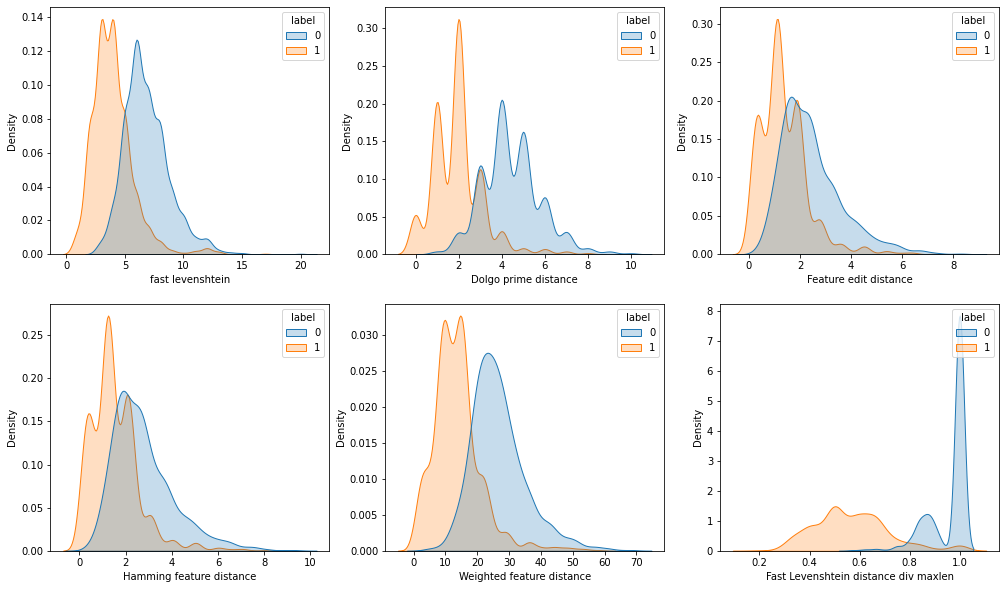

In [31]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= Epi_result, x=dist_arr[i,j], hue="label", shade=1, ax=axs[i][j], legend=True)

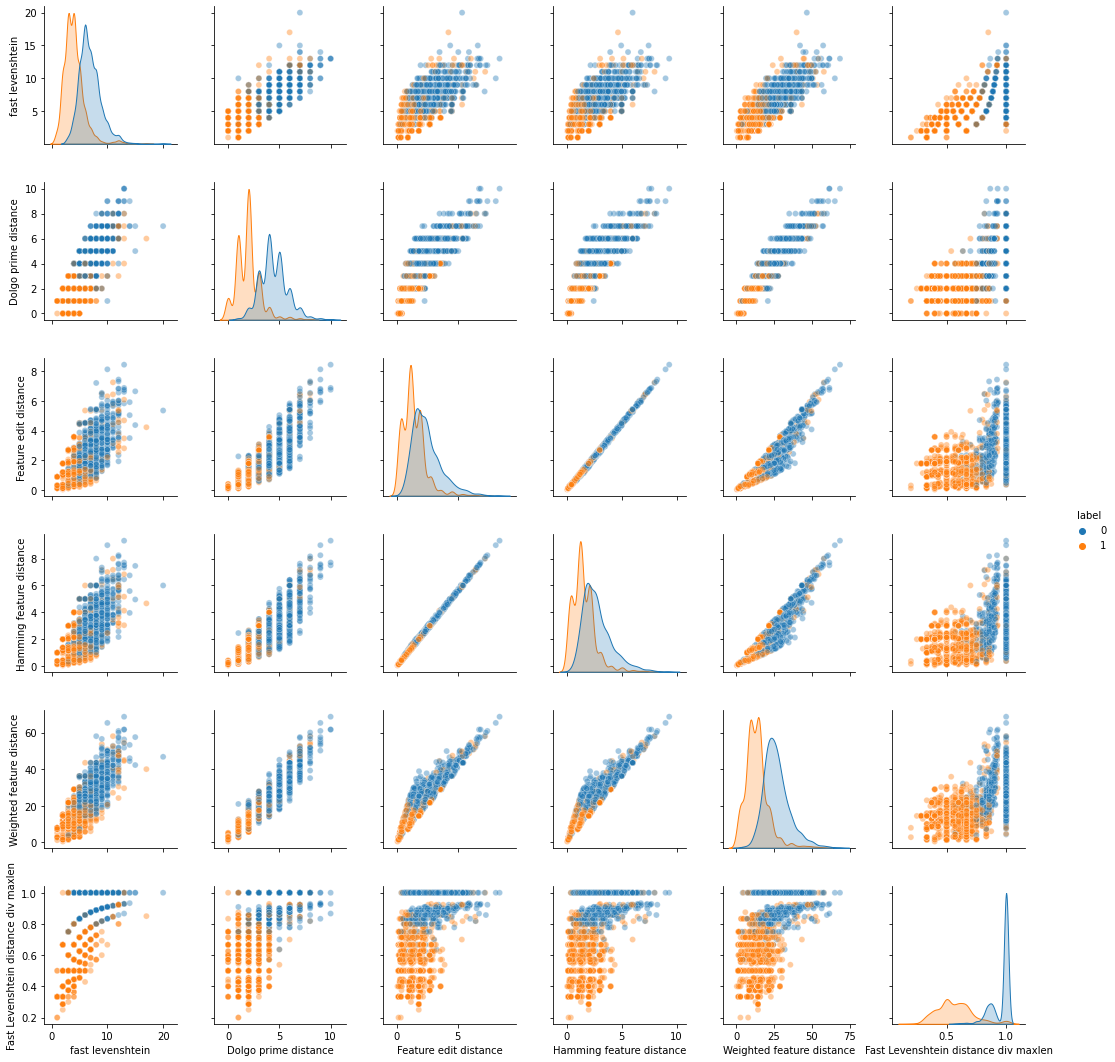

In [32]:
sns.pairplot(data=Epi_result, hue='label',plot_kws={'alpha':0.4})

In [33]:
max_accuracy = 0
max_accuracy_dist = ""
max_f1 = 0
max_f1_dist =""
for edit_dist in edit_dists_names:
    x_train, x_test, y_train, y_test = train_test_split(Epi_result[[edit_dist]], Epi_result["label"], train_size=0.6)
    clf = LogisticRegression().fit(x_train, y_train)
    report = classification_report(y_test, clf.predict(x_test), output_dict=True)
    if report["accuracy"] > max_accuracy:
        max_accuracy_dist = edit_dist
        max_accuracy = report["accuracy"]
    if report['weighted avg']["f1-score"] > max_f1:
        max_f1_dist = edit_dist
        max_f1 = report["accuracy"]
    report = pd.DataFrame(report).transpose()
    report.to_csv(f'Epi_{edit_dist}.csv', index= True)

In [34]:
print(f"{max_accuracy_dist} scored the best accuracy : {max_accuracy}")
print(f"{max_f1_dist} scored the best accuracy : {max_f1}")

Fast Levenshtein distance div maxlen scored the best accuracy : 0.9504132231404959
Fast Levenshtein distance div maxlen scored the best accuracy : 0.9504132231404959


## Working with Wiktionary's IPAs

In [35]:
Wiki_L1_L2 = pd.read_csv("Hindi-Persian.csv")

In [36]:
Wiki_L1_L2 = Wiki_L1_L2[Wiki_L1_L2["original_word_ipas"]!="[]"]
Wiki_L1_L2 = Wiki_L1_L2[Wiki_L1_L2["loan_word_ipas"]!="[]"]

In [37]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'..."
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/']
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a..."
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/']
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ..."


In [38]:
Wiki_L1_L2.shape

(724, 4)

In [39]:
for dist, name  in zip(edit_dists, edit_dists_names):
    Wiki_L1_L2[name] = Wiki_L1_L2.apply(lambda x:min([dist(i, j) for i in str(x["loan_word_ipas"]).strip('][').split(", ") for j in str(x["original_word_ipas"]).strip('][').split(", ")]), axis=1)

In [40]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",1,0,0.187500,0.208333,2.125,0.090909
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],0,0,0.000000,0.000000,0.000,0.000000
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",0,0,0.000000,0.000000,0.000,0.000000
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],5,0,0.333333,0.333333,3.250,0.454545
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ...",4,1,1.062500,1.166667,8.750,0.333333


In [41]:
Wiki_L1_L2_ = Wiki_L1_L2.copy()
Wiki_L1_L2_ = Wiki_L1_L2_.drop(edit_dists_names , axis=1)
idx = np.random.permutation(Wiki_L1_L2_.index)
Wiki_L1_L2_["original_word"] = Wiki_L1_L2_["original_word"].reindex(idx).reset_index(drop=True)
Wiki_L1_L2_["original_word_ipas"] = Wiki_L1_L2_["original_word_ipas"].reindex(idx).reset_index(drop=True)

In [42]:
Wiki_L1_L2["label"] = 1
Wiki_L1_L2_["label"] = 0
for dist, name  in zip(edit_dists, edit_dists_names):
    Wiki_L1_L2_[name] = Wiki_L1_L2_.apply(lambda x:min([dist(i, j) for i in str(x["loan_word_ipas"]).strip('][').split(", ") for j in str(x["original_word_ipas"]).strip('][').split(", ")]), axis=1)

In [43]:
Wiki_L1_L2_.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,label,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen
0,अंगूर,لاجورد,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['[lɒːd͡ʒˈwæɾd]', '[lɒːd͡ʒæˈwæɾd]', '[lɒːd͡ʒˈv...",0,10,4,2.729167,2.916667,27.00,0.666667
1,अंगूरी,عیاشی,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']","['/(ʔ)ə̯i.jɑː.ʃiː/', '/(ʔ)əj.jɑː.ʃiː/']",0,7,4,1.666667,1.875000,23.00,0.411765
2,अंजाम,مهم,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/mu.himm/', '/mohem/', '/muhimm/', '/mʊhɪmm/...",0,7,3,0.875000,1.000000,18.75,0.538462
3,अंदर,پاشیدن,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']","['/pɑːʃiːdan/', '/pɒːʃiːdan/', '/pɒːʃiːdæn/', ...",0,8,4,2.458333,2.750000,24.00,0.666667
5,अंदाज़,گذشته,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/ɡuðaʃta/', '/ɡʊzaʃta/', '/ɡozæʃte/', '/ɡuza...",0,8,4,2.625000,2.916667,32.50,0.666667


In [44]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen,label
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",1,0,0.187500,0.208333,2.125,0.090909,1
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],0,0,0.000000,0.000000,0.000,0.000000,1
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",0,0,0.000000,0.000000,0.000,0.000000,1
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],5,0,0.333333,0.333333,3.250,0.454545,1
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ...",4,1,1.062500,1.166667,8.750,0.333333,1


In [45]:
Wiki_result = pd.concat([Wiki_L1_L2, Wiki_L1_L2_])
Wiki_result = shuffle(Wiki_result).reset_index(drop=True)
Wiki_result.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,fast levenshtein,Dolgo prime distance,Feature edit distance,Hamming feature distance,Weighted feature distance,Fast Levenshtein distance div maxlen,label
0,ज़ोर,سردار,"['/d͡ʒoːɾ/', '/zoːɾ/']",['/sæɾˈdɒːɾ/'],6,3,2.729167,3.083333,22.500,0.500000,0
1,हमसाया,همسایه,"['/ɦəm.sɑː.jɑː/', '[ɦə̃m.s̪äː.jäː]']","['/hamsɑːja/', '/hamsɒːja/', '/hæmsɒːje/', '/h...",6,0,0.270833,0.291667,2.750,0.400000,1
2,जान,بزرگ,"['/d͡ʒɑːn/', '[d͡ʒä̃ːn̪]', '/d͡ʑɑ́ː.nɐ/', '/ˈd...","['/buzuɾɡ/', '/bʊzʊɾɡ/', '/bozoɾɡ/', '/buzuɾɡ/...",6,4,2.229167,2.541667,22.375,0.600000,0
3,शहद,شهد,"['/ʃə.ɦəd̪/', '[ʃɛ.ɦɛd̪]']","['/ʃahd/', '/ʃahd/', '/ʃæhd/', '/ʃahd/']",5,1,1.062500,1.166667,8.500,0.454545,1
4,मंज़िल,NaN,"['/mə̃.d͡ʒɪl/', '[mə̃.d͡ʒɪl̪]', '/mə̃.zɪl/', '...",NaN,11,4,2.166667,2.375000,18.875,1.000000,0


In [46]:
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr

array([['fast levenshtein', 'Dolgo prime distance',
        'Feature edit distance'],
       ['Hamming feature distance', 'Weighted feature distance',
        'Fast Levenshtein distance div maxlen']], dtype='<U36')

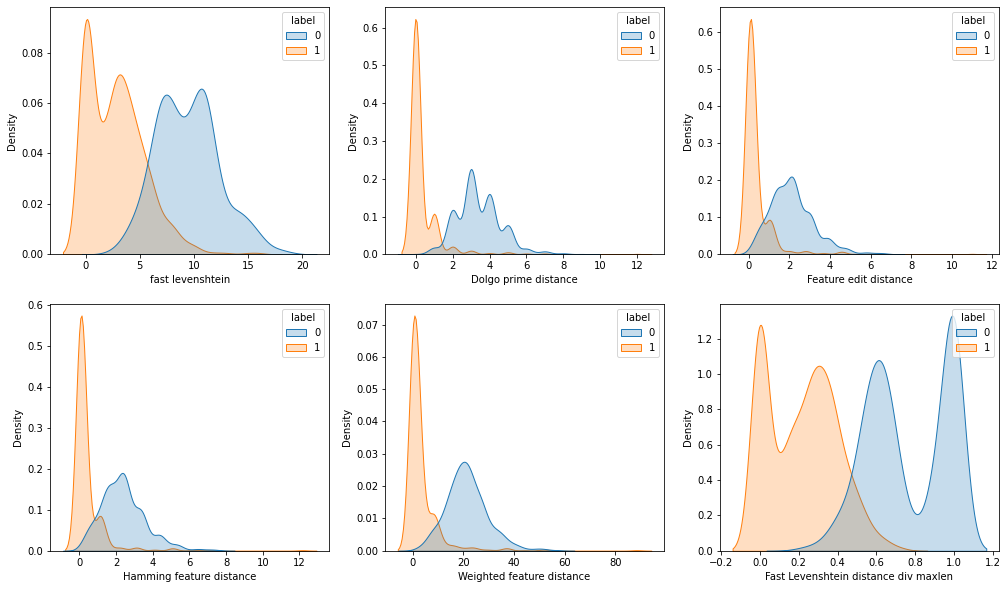

In [47]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= Wiki_result, x=dist_arr[i,j], hue="label", shade=1, ax=axs[i][j], legend=True)

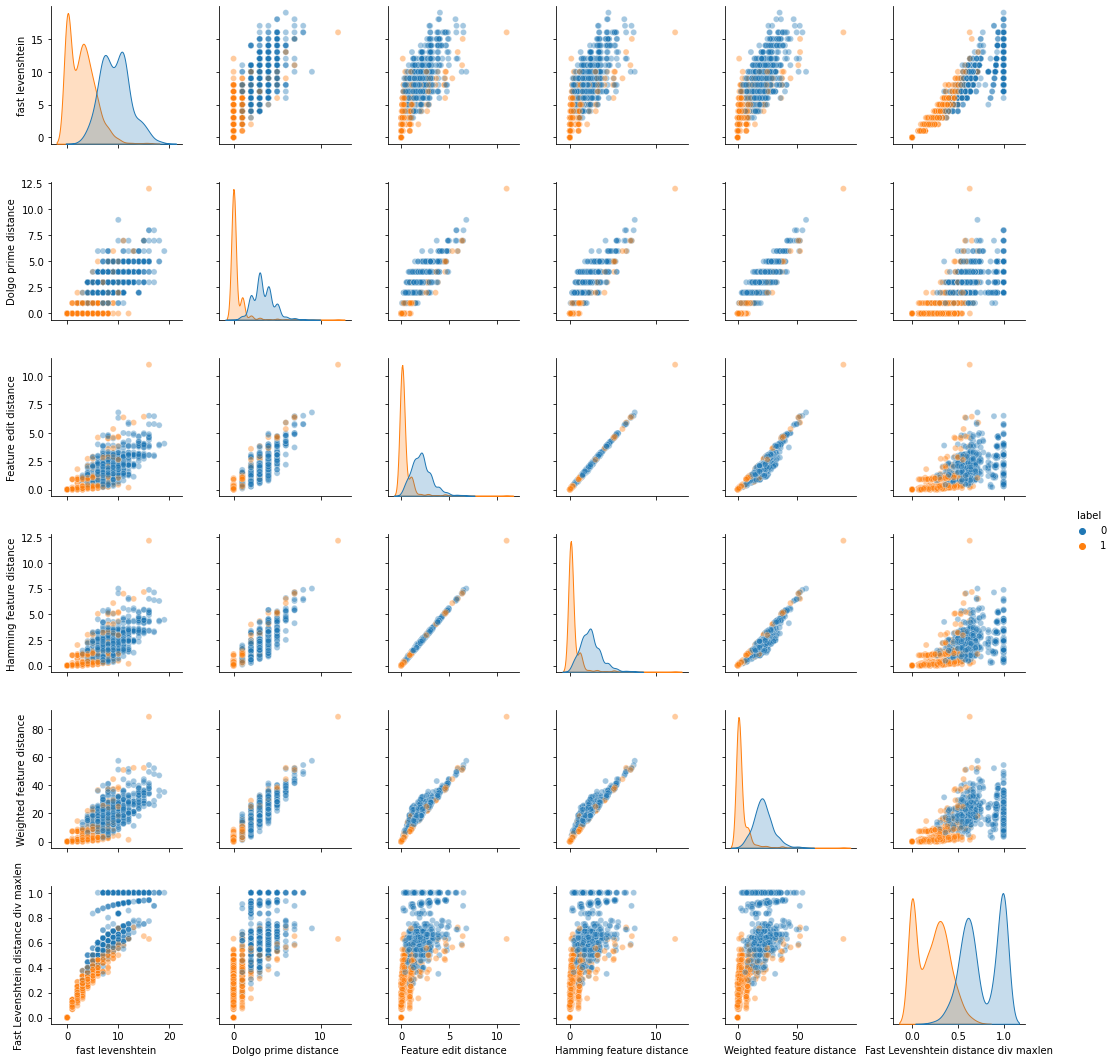

In [48]:
sns.pairplot(data=Wiki_result, hue='label',plot_kws={'alpha':0.4})
sns.set(rc={'figure.figsize':(40,40)})

In [49]:
max_accuracy = 0
max_accuracy_dist = ""
max_f1 = 0
max_f1_dist =""
for edit_dist in edit_dists_names:
    x_train, x_test, y_train, y_test = train_test_split(Wiki_result[[edit_dist]], Wiki_result["label"], train_size=0.6)
    clf = LogisticRegression().fit(x_train, y_train)
    report = classification_report(y_test, clf.predict(x_test), output_dict=True)
    if report["accuracy"] > max_accuracy:
        max_accuracy_dist = edit_dist
        max_accuracy = report["accuracy"]
    if report['weighted avg']["f1-score"] > max_f1:
        max_f1_dist = edit_dist
        max_f1 = report["accuracy"]
    report = pd.DataFrame(report).transpose()
    report.to_csv(f'Wiki_{edit_dist}.csv', index= True)

In [50]:
print(f"{max_accuracy_dist} scored the best accuracy : {max_accuracy}")
print(f"{max_f1_dist} scored the best accuracy : {max_f1}")

Dolgo prime distance scored the best accuracy : 0.9672413793103448
Dolgo prime distance scored the best accuracy : 0.9672413793103448
